In [14]:
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
import warnings
warnings.filterwarnings('ignore')

# DATA LOADING 

###  Have taken train size = 10000 and test size = 3000 

### piece_symbols = 'prbnkqPRBNKQ':  The uppercase letters represent the white pieces and lower case represents black pieces .

In [15]:
train_size = 10000
test_size = 3000

train = glob.glob("CV_FINAL/train/*.jpeg")
test = glob.glob("CV_FINAL/test/*.jpeg")

shuffle(train)
shuffle(test)

train = train[:train_size]
test = test[:test_size]

piece_symbols = 'prbnkqPRBNKQ'

### The function returns the Forsyth-Edwards Notation (FEN) representation of a chess position.

In [16]:
def fen_from_filename(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

In [28]:
def print_fen_from_filenames(filenames):
    for filename in filenames:
        fen_representation = fen_from_filename(filename)
        print(fen_representation)

print_fen_from_filenames(train[:5]) 


1K1b1n1N-Q6n-2N5-8-2r4R-6b1-1p6-2kn4
1N4k1-P3bn2-8-7B-5n2-1P4r1-4b3-3Kq3
1NBn1b2-6q1-4K3-1r6-N2p4-R7-5k2-8
1K5R-P7-B3n3-b2N2B1-qP4k1-8-3Rn3-7B
1b6-q3P3-nR6-q2N4-b1p5-7k-3r1p2-3RK3


## Displaying some images with its FEN

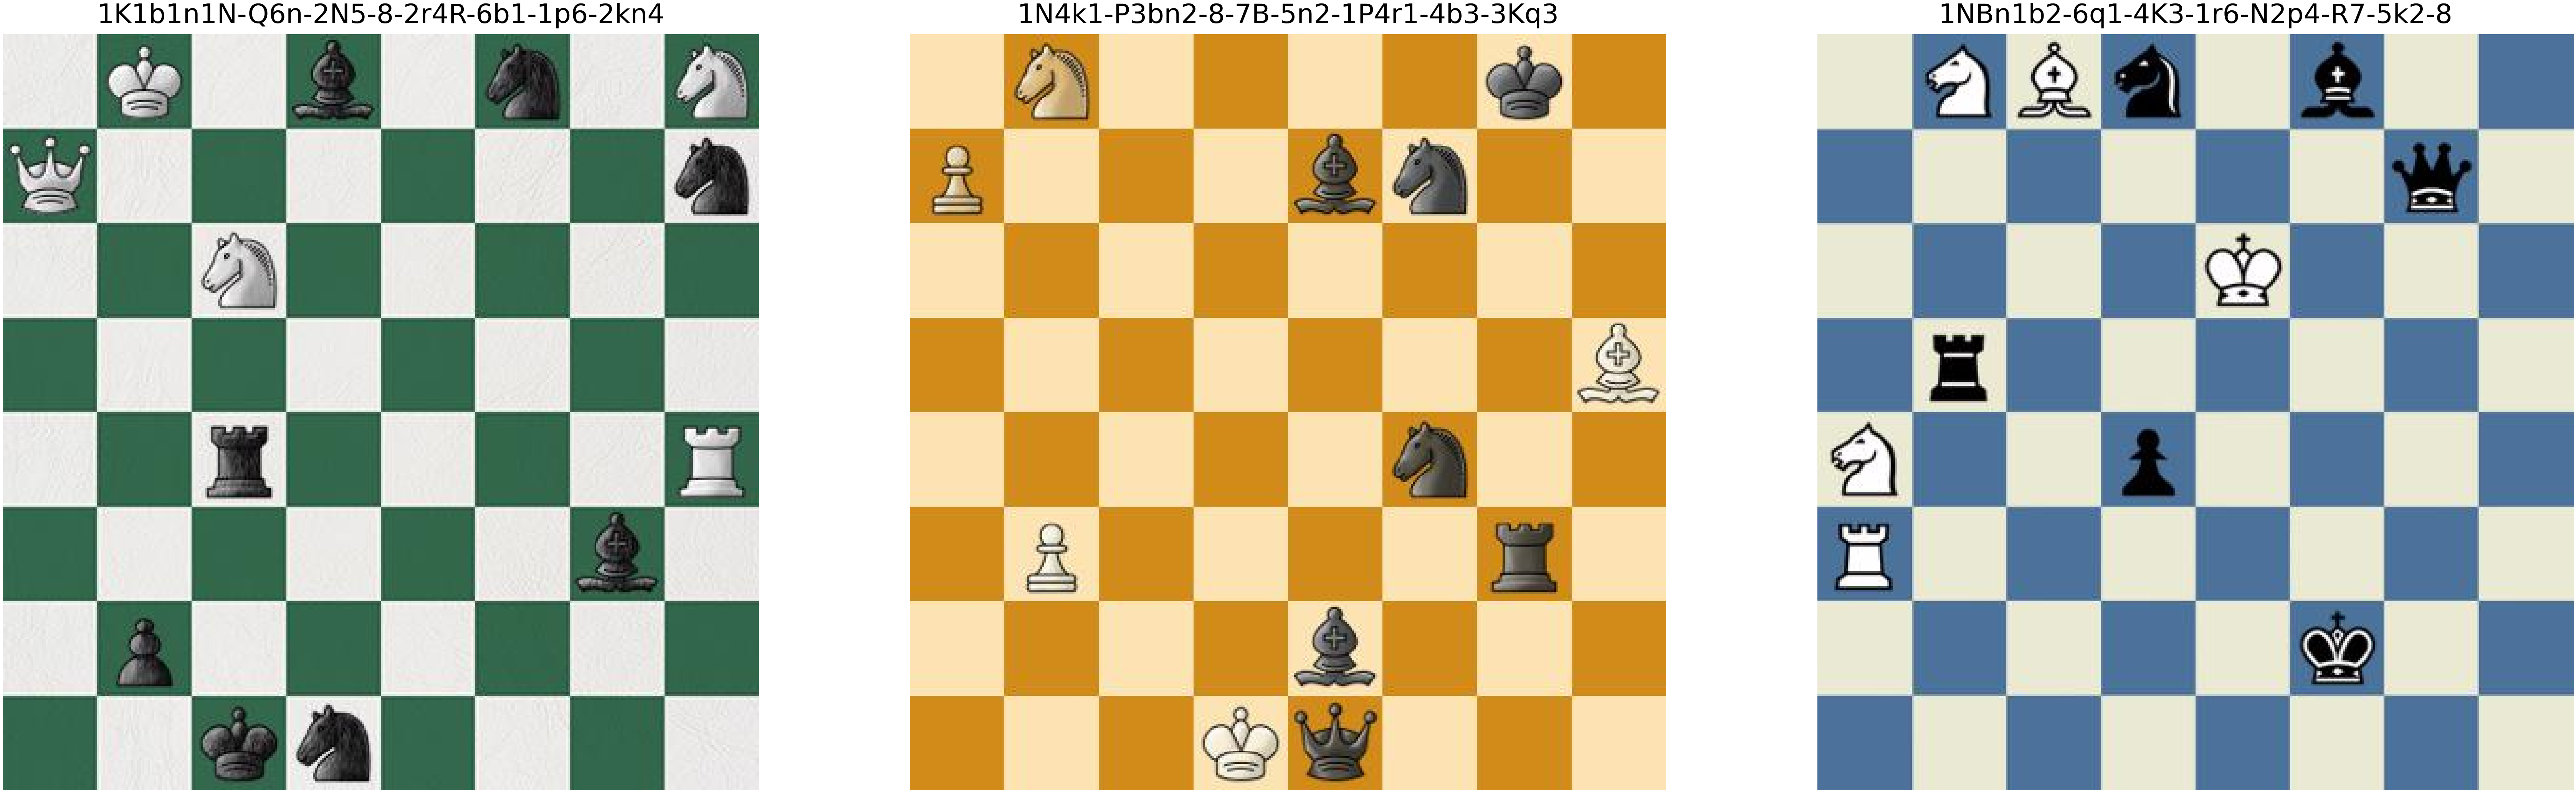

In [18]:
f, axarr = plt.subplots(1,3, figsize=(120, 120))

for i in range(0,3):
    axarr[i].set_title(fen_from_filename(train[i]), fontsize=70, pad=30)
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')

### This function converts a chessboard position represented in FEN  to a one-hot encoded representation. 
### It creates a 13x13 identity matrix, where each row corresponds to a chess piece or an empty square. 
### If it encounters a number, it appends the corresponding number of rows of the identity matrix (representing empty squares) to the output.
### If it finds a chess piece character, it appends the corresponding row of the identity matrix to the output. 
.

In [29]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output


### This function converts a one-hot encoded representation of a chessboard position back to FEN. 
###  If the cell represents an empty square (index 12), it adds a space character to the output string. 
### If it corresponds to a chess piece, it finds the piece character from the index and adds it to the output string. 
### Adds hyphens to separate rows in the FEN notation. Then, it replaces sequences of consecutive spaces with the number of spaces in a row to represent empty squares on the board.

In [30]:

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

### The function takes a chessboard image as input, downsamples it to a standard size, splits it into 64 square tiles of uniform size, and returns a 4D array with each square tile in a standardized format.

In [31]:
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

### The train_gen function takes a list of chessboard image file paths and It processes each image by converting it to a standardized format of square tiles using process_image() and obtains its FEN representation which is then converted to a one-hot encoded label using onehot_from_fen(). 
### The function yields batches of processed image data (x) and their corresponding one-hot encoded labels (y) one at a time during training..

In [21]:
def train_gen(features, labels, batch_size):
    for i, img in enumerate(features):
        y = onehot_from_fen(fen_from_filename(img))
        x = process_image(img)
        yield x, y


### The function takes a list of chessboard image file paths as input and iterates over the images one by one. For each image, it processes the image by converting it to a standardized format of square tiles using process_image(). 
### The function then yields batches of processed image data, allowing the model to make predictions on one batch at a time. This generator is useful for handling large datasets during prediction and ensures memory-efficient processing when resources may be limited.

In [ ]:

def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

### I used CNN for this model, which is ideal for image classification tasks. The CNN architecture consists of three convolutional layers with 32 filters of size (3, 3) to extract local patterns from the input chessboard images. Each convolutional layer is followed by a ReLU activation function to introduce non-linearity.

### After the convolutional layers, the output is flattened into a 1D vector, which is then passed through a Dense layer with 128 neurons to learn higher-level abstractions from the extracted features. Another ReLU activation function is applied after the dense layer to introduce non-linearity.

### To prevent overfitting, I added a Dropout layer with a rate of 0.4, which randomly deactivates 40% of the neurons during training. This enhances the model's ability to generalize to unseen data.

### The final output layer consists of 13 neurons, representing the 13 classes (chess pieces) the model needs to recognize. The softmax activation function is applied to the output layer to obtain a probability distribution over the classes, enabling multi-class classification.

### I compiled the model using categorical cross-entropy loss, the 'adam' optimizer for efficient training, and used accuracy as the evaluation metric.

### With this CNN architecture, the model should be able to accurately recognize different chess pieces on a chessboard from small-sized images.

In [22]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(25, 25, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(13))
model.add(Activation('softmax'))
model.compile(
  loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.fit_generator(train_gen(train, None, 64), steps_per_epoch=train_size)

10000/10000 [==============================] - 619s 62ms/step - loss: 0.0272 - accuracy: 0.9929


In [39]:
model.save("trained_model.h5")

In [32]:
res = (
  model.predict_generator(pred_gen(test, 64), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

### the code calculates the final accuracy of the model's predictions on the test set by comparing the predicted FEN strings with the actual FEN labels. 

In [34]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_filename(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.99567%


## Displaying predicted images 

In [38]:
def display_with_predicted_fen(image):
    actual_fen = fen_from_filename(image)
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    pred_fen = fen_from_onehot(pred[0])

    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(f"Actual FEN: {actual_fen}\nPredicted FEN: {pred_fen}")
    plt.show()



2/2 [==============================] - 0s 6ms/step


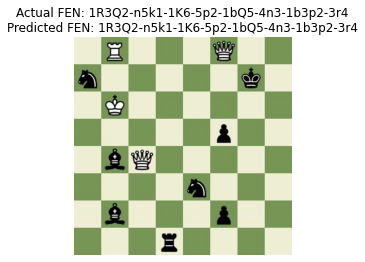

2/2 [==============================] - 0s 7ms/step


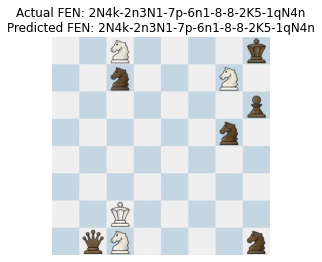

2/2 [==============================] - 0s 5ms/step


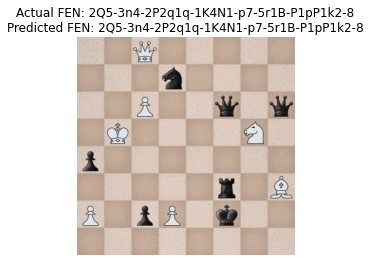

2/2 [==============================] - 0s 6ms/step


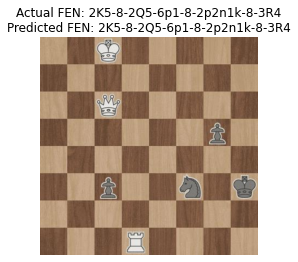

2/2 [==============================] - 0s 5ms/step


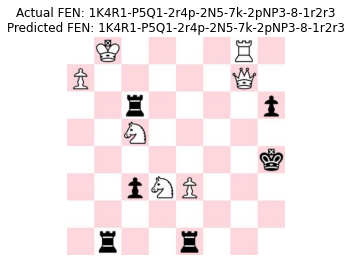

In [37]:
import random

# Geting random indices from the test dataset
random_indices = random.sample(range(len(test)), 5)

# Displaying the images and their predicted FEN values
for idx in random_indices:
    display_with_predicted_fen(test[idx])
